# Determining Whether or Not a Coin is Fair with Bayesian Stats

I'll start off easy and assume independence. A fair coin with two sides has a 50% probability of landing on heads and 50% on tails (p=0.5) [1- heads, 0- tails]  ... you use either a bernoulli or binomial distribution. If the process of tossing the heads and tails occurs in time, you can think of it as a general point process, which is built around the Poisson distribution in infinitesimal time bins (I'll explain below). 
 
The question of whether or not a coin is fair is a probability question. It can be tricky to decide what question to ask: if I flip this coin again, what is the probability it will turn up heads? If I flip this coin 100 times, what is the probability I will get 50 heads? The first is a question for the bernoulli, the second for the binomial.
   
Recall Bayes Theorem  ... H- hypothesis ... D- data

P(H | D) = [P(D | H) * P(H)] / P(D)

We can ask, what is the probability of a certain value of p given the data I have collected? That's P(H | D), which we get by calculating the likelihood P(D | H) , or the probability of the data given a certain value of p. The best candidate for p is the one that is most likely to have generated our data.

For this, we'll have the posterior ~ (bernoulli likelihood) * (beta prior) 

The beta is the conjugate prior for the binomial and bernoulli likelihoods. We set a prior on the p parameter from the binomial or bernoulli distributions. Then, given the conjugacy, the posterior also has a beta distribution. First, I'll calculate an unnormalized posterior manually, then we can use the theory to get an exact answer.

Binomial pdf = (n choose k) * p^k * (1-p)^(n-k)

Bernoulli pdf = p^k * (1-p)^(1-k)

Beta pdf = x^(a-1) * (1-x)^(b-1) / (BETA(a,b))

where BETA is the beta function

# Create binomial, bernoulli, beta pdf generating functions

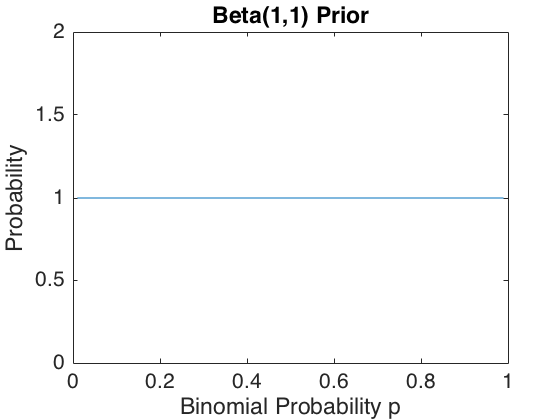

In [4]:
binomialPdf = @(p,n,k) (nchoosek(n,k).*(p.^k).*(1-p).^(n-k));
bernoulliPdf = @(p,k) (p.^k).*(1-p).^(1-k); % same as a single trial for binomial
betaPdf = @(x,a,b) (x.^(a-1).*(1-x).^(b-1)./beta(a,b));

% prior distribution
%  a common prior is the flat prior beta(1,1) or the non-informative beta(0.5,0.5)
%  if the prior is beta(c,c), then the contribution to the posterior is effectively the same as
%  having seen 2*c observations (an equal set of heads and tails)

% set range of values on (0,1)
pRange = 0.01:0.01:1-0.01;pRange = pRange';
a = 1;b = 1;
betaPrior = betaPdf(pRange,a,b);
plot(pRange,betaPrior);title(sprintf('Beta(%d,%d) Prior',a,b));
xlabel('Binomial Probability p');ylabel('Probability');

This prior makes intuitive sense in that it is flat. However, it is worth 2 previous observations. 

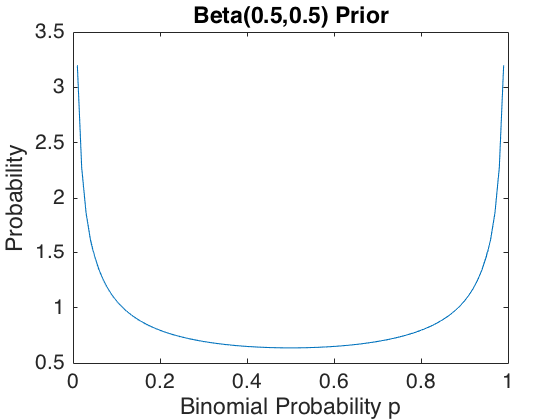

In [2]:
% try the beta(0.5,0.5) prior
a = 0.5;b = 0.5;
betaPrior = betaPdf(pRange,a,b);
plot(pRange,betaPrior);title(sprintf('Beta(%3.1f,%3.1f) Prior',a,b));
xlabel('Binomial Probability p');ylabel('Probability');

Oddly, though this prior looks a bit strange, it's "less informative" than the beta(1,1) because of what was mentioned above. The beta(1,1) is worth 2 observations. The beta(0.5,0.5) is worth 1 observation.

# Generate data, manually calculate unnormalized posterior

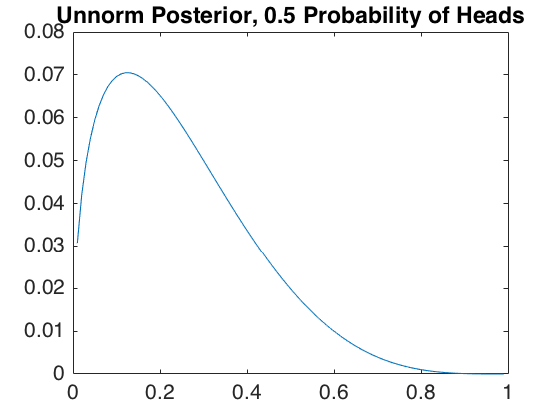

In [3]:
N = 5;
tempData = rand([N,1]);
coinProbability = 0.5; % equal probability or unbiased
binomialData = tempData<coinProbability;

% calculate the likelihood or the log-likelihood (more often the log-likelihood) ... in which case
%   you would do log-likelihood + log-prior = log-posterior

% each trial is a bernoulli trial, so we can use the simpler bernoulli pdf
%  we'll calculate the likelihood at each point ... below we'll do MCMC to generate samples
%  from the posterior

% recall that the log likelihood for independent data is just  SUM[i=1 to N] log(pdf)
%   you calculate the value of the likelihood at a range of different parameter values
loglikelihood = zeros(length(pRange),1);

for ii=1:N
    loglikelihood = loglikelihood+log(bernoulliPdf(pRange,binomialData(ii)));
end

unnormPosterior = exp(loglikelihood+log(betaPrior));
plot(pRange,unnormPosterior);title(sprintf('Unnorm Posterior, %2.1f Probability of Heads',coinProbability));

This is unnormalized. It's skewed because we only used 5 data points. We can't ask probability questions yet. Also, I've exponentiated the log posterior to give us the unnormalized posterior density. This is not possible as we get to higher numbers of observations. If the log-likelihood is something -1e5, then exp(log-likelihood+log-prior) is going to be effectively zero.

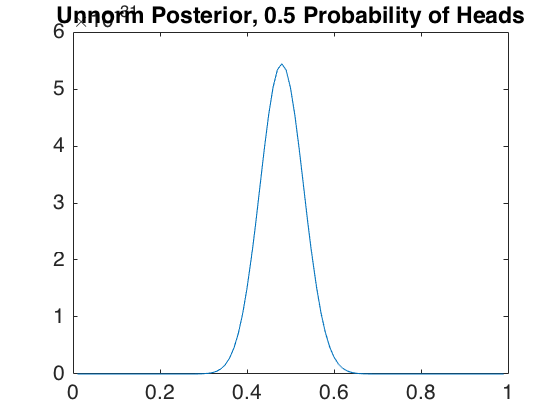

In [4]:
% repeat with higher N

N = 1e2;
tempData = rand([N,1]);
coinProbability = 0.5;
binomialData = tempData<coinProbability;


loglikelihood = zeros(length(pRange),1);

for ii=1:N
    loglikelihood = loglikelihood+log(bernoulliPdf(pRange,binomialData(ii)));
end

unnormPosterior = exp(loglikelihood+log(betaPrior));
plot(pRange,unnormPosterior);title(sprintf('Unnorm Posterior, %2.1f Probability of Heads',coinProbability));

Now, it's centered more tightly around 0.5, though we still have only 100 observations.

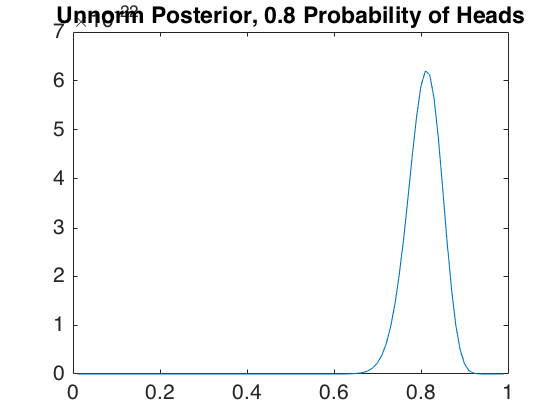

In [5]:
% repeat with different probability
N = 1e2;
tempData = rand([N,1]);
coinProbability = 0.8;
binomialData = tempData<coinProbability; % 80% chance of heads

loglikelihood = zeros(length(pRange),1);

for ii=1:N
    loglikelihood = loglikelihood+log(bernoulliPdf(pRange,binomialData(ii)));
end

unnormPosterior = exp(loglikelihood+log(betaPrior));
plot(pRange,unnormPosterior);title(sprintf('Unnorm Posterior, %2.1f Probability of Heads',coinProbability));

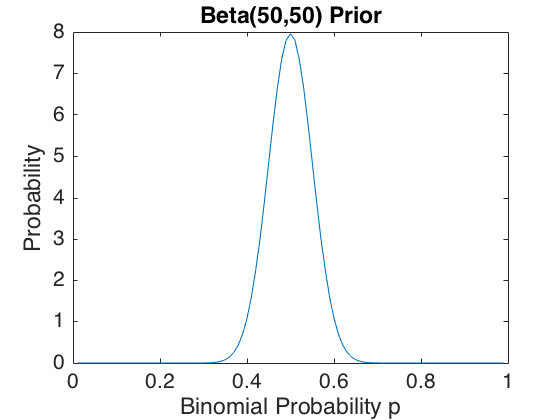

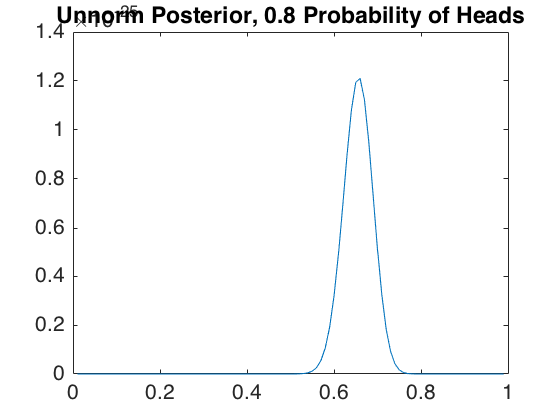

In [6]:
% repeat with a different prior (more informative), but keep the biased coin at 80% probability heads

a = 50;b = 50; % equivalent to 100 prior observations (equal probability of heads and tails)
betaPrior = betaPdf(pRange,a,b);

% use the same data

loglikelihood = zeros(length(pRange),1);

for ii=1:N
    loglikelihood = loglikelihood+log(bernoulliPdf(pRange,binomialData(ii)));
end

unnormPosterior = exp(loglikelihood+log(betaPrior));
figure();plot(pRange,unnormPosterior);title(sprintf('Unnorm Posterior, %2.1f Probability of Heads',coinProbability));

figure();plot(pRange,betaPrior);title(sprintf('Beta(%d,%d) Prior',a,b));
xlabel('Binomial Probability p');ylabel('Probability');

The prior biases the posterior toward the 50% equal probability of heads and tails.

# Exact Solution

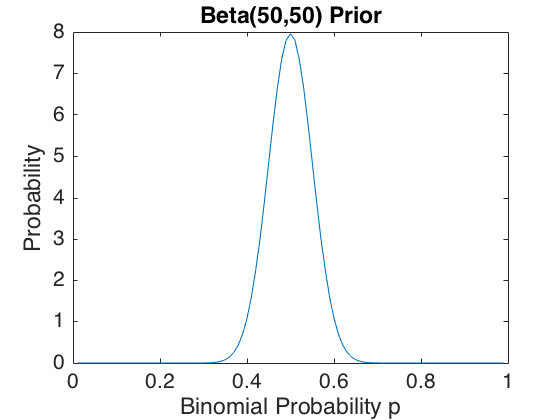

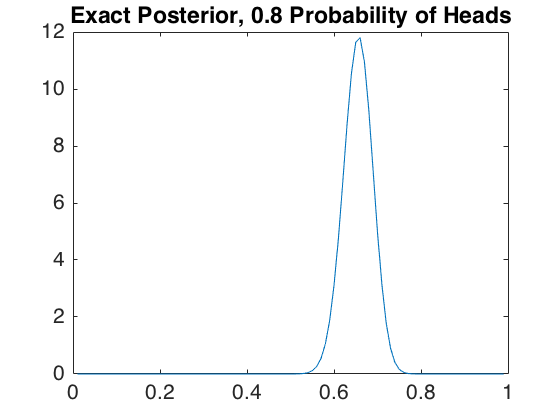

In [7]:
% For a binomial likelihood and beta prior, we have prior = beta(a,b) , 
%  data = n flips and k heads, posterior = Beta(a+k,b+n-k)

% For the bernoulli likelihood and beta prior, we have prior = beta(a,b), 
%  data = T tails and H heads, posterior = beta(a+H,b+T) ... the exact same thing as above.

% data is still stored as binomialData
H = sum(binomialData);T = N-H;
posterior = betaPdf(pRange,a+H,b+T);
figure();plot(pRange,posterior);title(sprintf('Exact Posterior, %2.1f Probability of Heads',coinProbability));

figure();plot(pRange,betaPrior);title(sprintf('Beta(%d,%d) Prior',a,b));
xlabel('Binomial Probability p');ylabel('Probability');

The exact posterior is a match to the unnormalized posterior, but now we can ask probability questions. 

In [8]:
% Below, I use the CDF and inverse CDF to ask probability questions about p (probability of flipping heads)
%  what is the probability that p is between 0.45 and 0.55?
%   use the CDF, which for the beta is the incomplete beta function [betainc(p,a,b) in matlab]
%   this is somewhat confusing, p here is the probability of flipping heads
%   but, when talking about CDF's, we also have another p, which is the cumulative probability of 
%   observing the data up to a certain point, such as P(p < 0.8) = ...

N = 1e2;
tempData = rand([N,1]);
coinProbability = 0.6;
binomialData = tempData<coinProbability;
H = sum(binomialData);T = N-H;

% recall that we are still using the informative prior, beta(50,50)
a = 50; b = 50;
fprintf('Informative prior: Beta(%3.1f,%3.1f)\n',a,b);
fprintf('Data: %d Heads, %d Tails\n\n',H,T);
P = betainc(0.55,a+H,b+T)-betainc(0.45,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.45,0.55,P);

% what about between 0.5 and 0.7?
P = betainc(0.7,a+H,b+T)-betainc(0.5,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.5,0.7,P);

% what is the 95% posterior interval? i.e. what are the values L and U such that P(L < p < U) = 0.95
%  we need to use the inverse beta cdf ... look up online or use matlab betainv ...
%   Be careful with the p's here
%   The p we've been using all along is the probability of heads, but CDF's and inverse CDF's also have
%   a p
confidence = 0.95;
alpha = 1-confidence; % 0.05;
L = betainv(alpha/2,a+H,b+T);U = betainv(1-alpha/2,a+H,b+T);
fprintf('95%% posterior interval for p: %3.2f to %3.2f\n\n',L,U);

% repeat with non-informative prior on the same data, beta(0.5,0.5)
a = 0.5;b = 0.5;
fprintf('Non-informative prior: Beta(%3.1f,%3.1f)\n',a,b);
fprintf('Data: %d Heads, %d Tails\n\n',H,T);
P = betainc(0.55,a+H,b+T)-betainc(0.45,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.45,0.55,P);

P = betainc(0.7,a+H,b+T)-betainc(0.5,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.5,0.7,P);

L = betainv(alpha/2,a+H,b+T);U = betainv(1-alpha/2,a+H,b+T);
fprintf('95%% posterior interval for p: %3.2f to %3.2f\n\n',L,U);

% repeat above with 1000 flips
N = 1e3;
tempData = rand([N,1]);
coinProbability = 0.6;
binomialData = tempData<coinProbability;
H = sum(binomialData);T = N-H;

a = 50; b = 50;
fprintf('Informative prior: Beta(%3.1f,%3.1f)\n',a,b);
fprintf('Data: %d Heads, %d Tails\n\n',H,T);
P = betainc(0.55,a+H,b+T)-betainc(0.45,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.45,0.55,P);

P = betainc(0.7,a+H,b+T)-betainc(0.5,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.5,0.7,P);

confidence = 0.95;
alpha = 1-confidence; % 0.05;
L = betainv(alpha/2,a+H,b+T);U = betainv(1-alpha/2,a+H,b+T);
fprintf('95%% posterior interval for p: %3.2f to %3.2f\n\n',L,U);

a = 0.5;b = 0.5;
fprintf('Non-informative prior: Beta(%3.1f,%3.1f)\n',a,b);
fprintf('Data: %d Heads, %d Tails\n\n',H,T);
P = betainc(0.55,a+H,b+T)-betainc(0.45,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.45,0.55,P);

P = betainc(0.7,a+H,b+T)-betainc(0.5,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.5,0.7,P);

L = betainv(alpha/2,a+H,b+T);U = betainv(1-alpha/2,a+H,b+T);
fprintf('95%% posterior interval for p: %3.2f to %3.2f\n',L,U);


Informative prior: Beta(50.0,50.0)
Data: 63 Heads, 37 Tails

Probability that p is between 0.45 and 0.55: 0.33
Probability that p is between 0.50 and 0.70: 0.97
95% posterior interval for p: 0.50 to 0.63

Non-informative prior: Beta(0.5,0.5)
Data: 63 Heads, 37 Tails

Probability that p is between 0.45 and 0.55: 0.05
Probability that p is between 0.50 and 0.70: 0.93
95% posterior interval for p: 0.53 to 0.72

Informative prior: Beta(50.0,50.0)
Data: 592 Heads, 408 Tails

Probability that p is between 0.45 and 0.55: 0.01
Probability that p is between 0.50 and 0.70: 1.00
95% posterior interval for p: 0.55 to 0.61

Non-informative prior: Beta(0.5,0.5)
Data: 592 Heads, 408 Tails

Probability that p is between 0.45 and 0.55: 0.00
Probability that p is between 0.50 and 0.70: 1.00
95% posterior interval for p: 0.56 to 0.62


When asking about a biased coin, we must have a specific question in mind. I think a good question might be: what is the probability that this coin lands on heads between 45% and 55% of the time? That's just 
P = betainc(0.55,a+H,b+T)-betainc(0.45,a+H,b+T) , where a and b are our prior parameters on the conjugate beta distribution. You can keep updating as you collect more data, just by adding to H or T and then recalculating. The more data we collect, the less the prior matters. Look up the posterior predictive distribution for how to predict what the next flip will be.

# MCMC to generate samples from the posterior

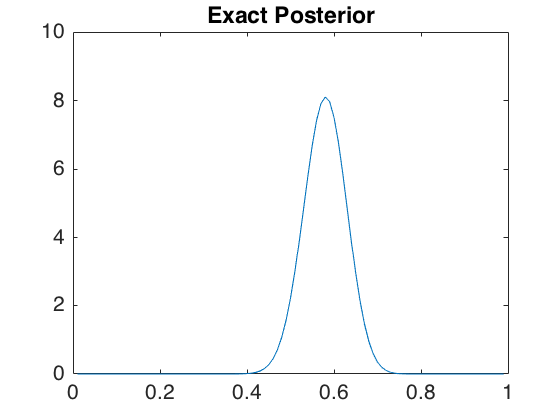

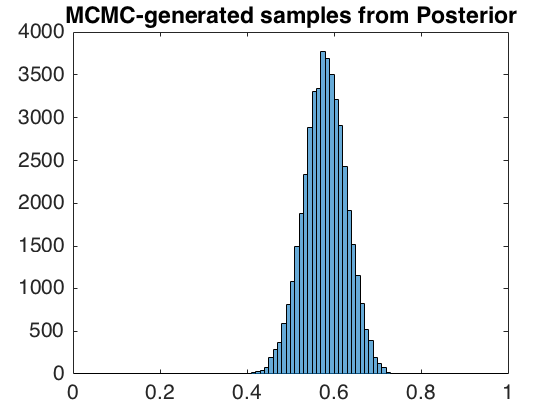

In [11]:
pRange = 0.01:0.01:1-0.01;
a = 0.5;b = 0.5;

N = 1e2;
tempData = rand([N,1]);
coinProbability = 0.6;
binomialData = tempData<coinProbability;

% this is easily extendable to many-parameter models
numIter = 1e5;burnIn = 1e4;
numParameters = 1;
pSamples = zeros(numIter,numParameters);

% often easy to initialize with a random number generated from the prior
%   other, more complex, methods exist for initialization, such as method of
%   moments estimators
pSamples(1) = betarnd(a,b);

% the proposal distribution will randomly propose new values for p, we'll use a normal distribution
%   with a small sigma to avoid jumping too often outside our range
sigma = 0.1;

% set bounds on p so we cannot go outside the range of values
Bounds = [0,1];

% calculate the number of rejected samples to titrate the proposal distribution (if needed)
rejectTracker = zeros(numIter,1);

% get the log likelihood and log prior at the current position in the parameter space
pPrevLogLikelihood = 0;
for jj=1:N
    pPrevLogLikelihood = pPrevLogLikelihood+log(bernoulliPdf(pSamples(1),binomialData(jj)));
end
pPrevLogPrior = log(betaPdf(pSamples(1),a,b));

for ii=2:numIter
    % use the proposal distribution to generate a new sample
    pStar = pSamples(ii-1)+normrnd(0,sigma);
    
    % reject the new sample if it's out of bounds and use the previous value as the
    %  correct value for this iteration
    %   ... you must do this or you'll generate samples from a different distribution
    if pStar < Bounds(1) || pStar > Bounds(2)
        pSamples(ii) = pSamples(ii-1);
        rejectTracker(ii) = 1;
    else
        % calculate log likelihood and log prior at current sample pStar
        pStarLogLikelihood = 0;
        for jj=1:N
            pStarLogLikelihood = pStarLogLikelihood+log(bernoulliPdf(pStar,binomialData(jj)));
        end
        pStarLogPrior = log(betaPdf(pStar,a,b));
        
        % get the log ratio of current step to previous step
        logA = (pStarLogLikelihood+pStarLogPrior)-(pPrevLogLikelihood+pPrevLogPrior);
        
        % if logA is really big (the current position is more likely), then we'll almost certainly
        %   jump to that position ... if logA is really small, then we'll almost certainly
        %   stay at the current position
        if log(rand) < logA
            pSamples(ii) = pStar;
            pPrevLogLikelihood = pStarLogLikelihood;
            pPrevLogPrior = pStarLogPrior;
        else
            pSamples(ii) = pSamples(ii-1);
            rejectTracker(ii) = 1;
        end
    end
end

% often good to check if the samples are correlated using the auto-correlation function
%   here, i'll just skip every other sample (you don't want them to be correlated)
%    if they are correlated, that's often a sign that the proposal distribution is off
posteriorSamples = pSamples(burnIn:2:end);
figure();histogram(posteriorSamples,0:0.01:1);
title(sprintf('MCMC-generated samples from Posterior'));

% also show the exact posterior for comparison
H = sum(binomialData);T = N-H;
exactPosterior = betaPdf(pRange',a+H,b+T);
figure();plot(pRange,exactPosterior);title('Exact Posterior');

We used a non-informative beta(0.5,0.5) prior and the probability of heads was 0.6. The MCMC samples match the exact posterior very well. Now, we can use the samples to ask probability questions and compare the answers to those given by the exact posterior.

In [14]:
a = 0.5; b = 0.5;
fprintf('Results from the Exact Posterior\n');
fprintf('Data: %d Heads, %d Tails\n\n',H,T);
P = betainc(0.55,a+H,b+T)-betainc(0.45,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.45,0.55,P);

P = betainc(0.7,a+H,b+T)-betainc(0.5,a+H,b+T);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.5,0.7,P);

confidence = 0.95;
alpha = 1-confidence; % 0.05;
L = betainv(alpha/2,a+H,b+T);U = betainv(1-alpha/2,a+H,b+T);
fprintf('95%% posterior interval for p: %3.2f to %3.2f\n\n',L,U);

% use empirical measures (proportions and quantiles) with the posterior samples to ask the same questions
samples = posteriorSamples(posteriorSamples<0.55 & posteriorSamples>0.45);
P = length(samples)./length(posteriorSamples);
fprintf('Approximate Results from MCMC-generated Samples\n');
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.45,0.55,P);

samples = posteriorSamples(posteriorSamples<0.7 & posteriorSamples>0.5);
P = length(samples)./length(posteriorSamples);
fprintf('Probability that p is between %3.2f and %3.2f: %3.2f\n',0.5,0.7,P);

[Q] = quantile(posteriorSamples,[alpha/2,1-alpha/2]);
fprintf('95%% posterior interval for p: %3.2f to %3.2f\n\n',Q(1),Q(2));

Results from the Exact Posterior
Data: 58 Heads, 42 Tails

Probability that p is between 0.45 and 0.55: 0.27
Probability that p is between 0.50 and 0.70: 0.94
95% posterior interval for p: 0.48 to 0.67

Approximate Results from MCMC-generated Samples
Probability that p is between 0.45 and 0.55: 0.27
Probability that p is between 0.50 and 0.70: 0.94
95% posterior interval for p: 0.48 to 0.67


Perfect agreement between the two methods for this level of accuracy.

# Throw away the assumption of independent samples

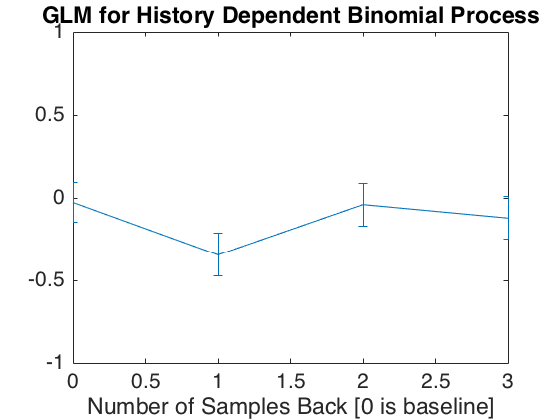

In [19]:
% if we want to think about this same question when there is some history dependence, 
%    we can use a frequentist GLM model
%   see below for one way to set this in a Bayesian framework

% imagine the data are generated sequentially, [1 0 1 0 0 0 1 0], but the probability of a heads 
%  on the next flip decreases slightly if the previous flip was a heads

pHeads = 0.5;pHeads_afterHeads = 0.4;
N = 1e3;

histDependent_binomialData = zeros(N,1);
histDependent_binomialData(1) = rand<pHeads;
for ii=2:N
    if histDependent_binomialData(ii-1) == 1
        histDependent_binomialData(ii) = rand<pHeads_afterHeads;
    else
        histDependent_binomialData(ii) = rand<pHeads;
    end
end

% now we have incorporated history dependence, which we can model in a glm
%   we now have conditionally independent samples, they're independent conditional
%   on our knowledge that a previous heads reduces our probability of a heads

% for a binomial GLM, we're saying that the data has a certain mean [mu] (the probability of heads),
%  but that the mean depends on some other information in the following way:
%    log(mu/(1-mu)) = X*c
%      note that c is usually called b or beta, but we've already used those variables

% if we want to incorporate history dependence, then mu depends on previous samples

% X is called the design matrix
%  we'll make X depend on the previous 3 samples
% y will be the data (but, we need to skip the first 3 because we need to build up our history dependence)
%  matlab automatically adds a baseline parameter, so we'll make the design matrix with 3 parameters and
%   matlab will add a fourth

y = histDependent_binomialData(4:end);
X = [histDependent_binomialData(3:end-1),histDependent_binomialData(2:end-2),histDependent_binomialData(1:end-3)];

[c,dev,stats] = glmfit(X,y,'binomial');

% if log(mu/(1-mu)) = X*c ... then mu = exp(X*c)/(1+exp(X*C))
%   so you can think about how a previous string of samples will affect the current estimate
figure();errorbar([0,1,2,3],c,stats.se);axis([0 3 -1 1]);title('GLM for History Dependent Binomial Process');
xlabel('Number of Samples Back [0 is baseline]');

Since we fit a model that follows log(mu/(1-mu)) ... if the baseline probability is 0.5, then log(0.5/0.5) = 0, and the coefficient will be approximately 0. As we can see, the previous sample has the strongest effect on the current sample (it lowers the probability of a heads). This is where the problem gets complicated ... the complex history-dependent interactions of a process can be elusive. You'll probably have to try a bunch of different models and see which best fits the data. Here is an example of one goodness-of-fit measure you can use to compare different models.

In [23]:
% MODEL 1 ... no history dependence, just one parameter for mu (also known as p,
%    the probability of a heads), must tell matlab to not add the constant that it usually adds
y = histDependent_binomialData(1:end);
X = [ones(N,1)];

numParameters1 = 1;
[c1,dev1] = glmfit(X,y,'binomial','constant','off');

% MODEL 2 ... history dependence back one sample
y = histDependent_binomialData(2:end);
X = [histDependent_binomialData(1:end-1)];

numParameters2 = 2;
[c2,dev2] = glmfit(X,y,'binomial');

% MODEL 3 ... history dependence back two samples
y = histDependent_binomialData(3:end);
X = [histDependent_binomialData(2:end-1),histDependent_binomialData(1:end-2)];

numParameters3 = 3;
[c3,dev3] = glmfit(X,y,'binomial');

% according to the theory of GLM, the difference of deviances between two models (smaller-bigger model)
%   follows a chi-square distribution with degrees of freedom equal to the number of
%   parameters by which the two models differ (this only works for nested models, i.e.
%   if one model completely contains the other model and has additional parameters)

% the deviance is the generalization of the sum of squared residuals to probability
%  models that are not normal ... so, a big deviance is indicative of a large residual
%  variance ... if a model adds a parameter and dramatically reduces the deviance, then
%  you'll get a huge number for the difference of deviances, which will fall out in the
%  tail of the chi-square distribution

%  if the p value for the test is less than 0.05, or whatever value you choose, then
%   the larger model fits the data significantly better than the smaller one

% compare 1 to 2
diffDev12 = dev1-dev2;degreesFreedom = numParameters2-numParameters1;

testStat = 1-chi2cdf(diffDev12,degreesFreedom);
fprintf('Model 1 versus Model 2 p-value: %3.2e\n',testStat);

% compare 2 to 3
diffDev23 = dev2-dev3;degreesFreedom = numParameters3-numParameters2;
testStat = 1-chi2cdf(diffDev23,degreesFreedom);
fprintf('Model 2 versus Model 3 p-value: %3.2f\n',testStat);

Model 1 versus Model 2 p-value: 3.21e-03
Model 2 versus Model 3 p-value: 0.30


So, given these p-values, we can reject the null hypothesis in the first case. We can be fairly certain that adding the history dependence to the model created a better fit to the data. However, when we compared model 2 to model 3, the chi-square p-value was greater than 0.05 and therefore adding the additional parameter did not help us very much. You can use this kind of procedure to compare a variety of nested model structures and you can incorporate more complex models by adding to the design matrix. The multiple comparisons problem arises here, but it's not as dire as in other cases.

To frame this in a Bayesian context, then the parameters of the model
must have prior distributions and you can use MCMC to generate samples from the posterior. The only concern is that it's harder to think about what the prior should be when you have a bunch of these coefficient parameters. They should be independent, so that's a start.

# More Complex History Dependence

In [1]:
% let's say we want the following history-dependent structure
%    if we just saw a heads AND did not see one two ago, probability = 0.45
%    if we saw a heads two ago AND just saw a heads, probability = 0.2
%    if we saw a heads two ago AND did not just see a heads, probability = 0.48

N = 1e3;

baseline = 0.5;
oneBack = 0.45;
twoBack_oneBack = 0.3;
twoBack = 0.56;

histDependent_binomData = zeros(N,1);

% just initialize with two randomly chosen values according to some baseline
histDependent_binomData(1) = rand<baseline;
histDependent_binomData(2) = rand<baseline;

for ii=3:N
    % case 1 ... heads both of the previous two samples
    if histDependent_binomData(ii-2) == 1 && histDependent_binomData(ii-1) == 1
        histDependent_binomData(ii) = rand<twoBack_oneBack;
    % case 2 ... heads two back but not one back
    elseif histDependent_binomData(ii-2) == 1 && histDependent_binomData(ii-1) == 0
        histDependent_binomData(ii) = rand<twoBack;
    % case 3 ... heads one back but not two back
    elseif histDependent_binomData(ii-2) == 0 && histDependent_binomData(ii-1) == 1
        histDependent_binomData(ii) = rand<oneBack;
    else
        histDependent_binomData(ii) = rand<baseline;
    end
end


% MODEL 1 ... flat probability, also called the null model
y = histDependent_binomData(1:end);
X = [ones(N,1)];

numParameters1 = 1;
[c1,dev1] = glmfit(X,y,'binomial','constant','off');

% MODEL 2 ... history dependence back one sample
y = histDependent_binomData(2:end);
X = [histDependent_binomData(1:end-1)];

numParameters2 = 2;
[c2,dev2] = glmfit(X,y,'binomial');

% MODEL 3 ... history dependence back two samples
y = histDependent_binomData(3:end);
X = [histDependent_binomData(2:end-1),histDependent_binomData(1:end-2)];

numParameters3 = 3;
[c3,dev3] = glmfit(X,y,'binomial');

% MODEL 4 ... captures the exact structure of the data as we generated it
y = histDependent_binomData(3:end);
oneSampleBack = histDependent_binomData(2:end-1);
twoSamplesBack = histDependent_binomData(1:end-2);

% one coefficient for case 1 (heads two samples back and heads one sample back)
temp = oneSampleBack==1 & twoSamplesBack==1;
X = [temp];

% one coefficient for case 2 (heads two samples back but not one sample back)
temp = oneSampleBack==0 & twoSamplesBack==1;
X = [X,temp];

% one coefficient for case 3 (heads one sample back but not two samples back)
temp = oneSampleBack==1 & twoSamplesBack==0;
X = [X,temp];

numParameters4 = 4;
[c4,dev4] = glmfit(X,y,'binomial');

% compare deviances

% model 1 versus 2, 3 and 4 ... are they better than the null model?
diffDev12 = dev1-dev2;degreesFreedom = numParameters2-numParameters1;

testStat = 1-chi2cdf(diffDev12,degreesFreedom);
fprintf('Model 1 versus Model 2 p-value: %3.2e\n',testStat);

diffDev13 = dev1-dev3;degreesFreedom = numParameters3-numParameters1;

testStat = 1-chi2cdf(diffDev13,degreesFreedom);
fprintf('Model 1 versus Model 3 p-value: %3.2e\n',testStat);

diffDev14 = dev1-dev4;degreesFreedom = numParameters4-numParameters1;

testStat = 1-chi2cdf(diffDev14,degreesFreedom);
fprintf('Model 1 versus Model 4 p-value: %3.2e\n',testStat);

% model 3 versus 4 ... does the last model do better than the third one?
%   technically, 3 and 4 are not nested versions of each other but
%   this should not dramatically affect the results as they're within the
%   same family of history-dependent models
diffDev34 = dev3-dev4;degreesFreedom = numParameters4-numParameters3;

testStat = 1-chi2cdf(diffDev34,degreesFreedom);
fprintf('Model 3 versus Model 4 p-value: %3.2e\n',testStat);


% we can also test all of these against a saturated model
%   the saturated model is the best we can possibly do as
%   it has one parameter for every data point, so we can
%   just memorize the data ... but the chi-square test for
%   difference of deviances effectively penalizes against
%   high numbers of parameters 

% we don't actually have to make the saturated model because the deviance
%   is already designed to compare against a saturated model

% model 4 versus saturated model ... degrees of freedom is equal to 
%   the length of the vector y that we input into glmfit minus the 
%   number of parameters in model 4
diffDev4Sat = dev4;degreesFreedom = (N-2)-numParameters4;

testStat = 1-chi2cdf(diffDev4Sat,degreesFreedom);
fprintf('Model 4 versus Saturated Model p-value: %3.2e\n',testStat);

Model 1 versus Model 2 p-value: 2.70e-05
Model 1 versus Model 3 p-value: 5.89e-05
Model 1 versus Model 4 p-value: 2.23e-06
Model 3 versus Model 4 p-value: 2.02e-03
Model 4 versus Saturated Model p-value: 1.47e-13


From these results, we can accept model 4 as the best among this set of models. Model 4 significantly captures the variability in the data while also limiting the number of parameters (that's the final test against the saturated model). Notice that the p-value between model 3 and model 4 is 3.7e-3. That's small but also significantly less than the difference between model 1 and model 3. Maybe for certain purposes, model 3 would suffice. However, if we repeated this with N = 1e4 or N = 1e5, the p-value for this test between 3 and 4 would decrease dramatically. The main problem from here is thinking about what types of history-dependent structure to expect in your data. You could fit massive models that try a wide variety of history-dependent structures, then start to throw away parameters that are close to zero or that do not significantly alter some aspect of the model fit.

# Attempt to put this in a Bayesian framework

In [2]:
% we'll try to fit model 4 from above
%  the parameters turned out to be ...

display(c4);

c4 =

   -0.0827
   -0.4971
    0.4437
   -0.1389


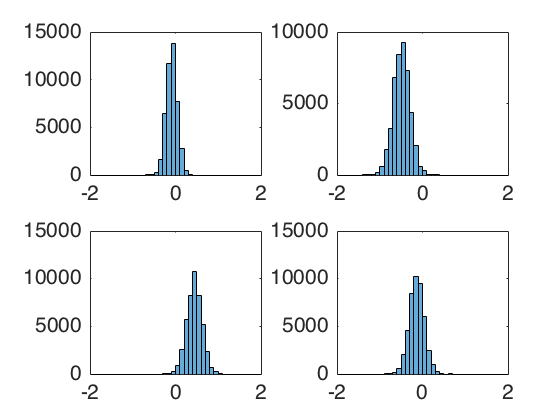

c4 =

   -0.0827
   -0.4971
    0.4437
   -0.1389

95% posterior interval for coeff 1: -0.33 to 0.16
Posterior mean for coeff 1: -0.09
95% posterior interval for coeff 2: -0.87 to -0.11
Posterior mean for coeff 2: -0.49
95% posterior interval for coeff 3: 0.08 to 0.78
Posterior mean for coeff 3: 0.44
95% posterior interval for coeff 4: -0.47 to 0.21
Posterior mean for coeff 4: -0.13


In [5]:
% if you think about it, these parameters can be any real number
%  if the model is log(mu/(1-mu)) = Xc , then
%     mu/(1-mu) = exp(Xc)
%    => mu = (1-mu)*exp(Xc)
%    => mu = 1*exp(Xc)-mu*exp(Xc)
%    => mu+mu*exp(Xc) = exp(Xc)
%    => mu(1+exp(Xc)) = exp(Xc)
%    => mu = exp(Xc) / (1+exp(Xc))

%  this mu is just p in the bernoulli likelihood
%    we calculate mu, then plug it into the bernoulli
%    likelihood equation along with the data

% mu is a sigmoid function of the coefficient inputs
%   and the input range for the sigmoid is all real numbers

% let's say we take a multivariate normal prior for the parameters
%  the likelihood is still binomial
% we can do MCMC and generate samples from the posterior

numParameters = 4;
mvNormPdf = @(x,mu,sigma) exp(-0.5.*(x-mu)'*pinv(sigma)*(x-mu))./sqrt(det(2.*pi.*sigma));

% informative prior ... hoping the data will drown it out
%   also, the prior for each parameter is set to mean zero
%   which means the posterior will skew toward zero, making
%   us less likely to find any given parameter significant

priorMu = zeros(numParameters,1);
priorSigma = diag(ones(numParameters,1));

numIter = 1e5;burnIn = 1e4;
pSamples = zeros(numParameters,numIter);

% often easy to initialize with a random number generated from the prior
%   other, more complex, methods exist for initialization, such as method of
%   moments estimators

pSamples(:,1) = [normrnd(0,1),normrnd(0,1),normrnd(0,1),normrnd(0,1)]';

% the proposal distribution will randomly propose new values for p, we'll use a normal distribution
%   with a small sigma to avoid jumping too often outside our range
sigma = 0.25;

% no need for bounds

% calculate the number of rejected samples to titrate the proposal distribution (if needed)
rejectTracker = zeros(numIter,1);

%  get data in a nice format
y = histDependent_binomData(3:end);

N_reduce = length(y);
oneSampleBack = histDependent_binomData(2:end-1);
twoSamplesBack = histDependent_binomData(1:end-2);

data_coeff1 = ones(N_reduce,1);
data_coeff2 = oneSampleBack==1 & twoSamplesBack ==1;
data_coeff3 = oneSampleBack==0 & twoSamplesBack==1;
data_coeff4 = oneSampleBack==1 & twoSamplesBack==0;

X = [data_coeff1,data_coeff2,data_coeff3,data_coeff4];

% get the log likelihood and log prior at the current position in the parameter space
mu = exp(X*pSamples(:,1))./(1+exp(X*pSamples(:,1)));
pPrevLogLikelihood = sum(log(bernoulliPdf(mu,y)));

pPrevLogPrior = log(mvNormPdf(pSamples(:,1),priorMu,priorSigma));

for ii=2:numIter
    % use the proposal distribution to generate a new sample
    pStar = pSamples(:,ii-1)+normrnd(0,sigma,[numParameters,1]);
    
    % reject the new sample if it's out of bounds and use the previous value as the
    %  correct value for this iteration
    %   ... you must do this or you'll generate samples from a different distribution

        % calculate log likelihood and log prior at current sample pStar
        mu = exp(X*pStar)./(1+exp(X*pStar));
        pStarLogLikelihood = sum(log(bernoulliPdf(mu,y)));

        pStarLogPrior = log(mvNormPdf(pStar,priorMu,priorSigma));
        
        % get the log ratio of current step to previous step
        logA = (pStarLogLikelihood+pStarLogPrior)-(pPrevLogLikelihood+pPrevLogPrior);
        
        % if logA is really big (the current position is more likely), then we'll almost certainly
        %   jump to that position ... if logA is really small, then we'll almost certainly
        %   stay at the current position
        if log(rand) < logA
            pSamples(:,ii) = pStar;
            pPrevLogLikelihood = pStarLogLikelihood;
            pPrevLogPrior = pStarLogPrior;
        else
            pSamples(:,ii) = pSamples(:,ii-1);
            rejectTracker(ii) = 1;
        end
end

% often good to check if the samples are correlated using the auto-correlation function
%   here, i'll just skip every other sample (you don't want them to be correlated)
%    if they are correlated, that's often a sign that the proposal distribution is off
posteriorSamples = pSamples(:,burnIn:2:end);

posteriorMean = mean(posteriorSamples,2);
posteriorCovariance = cov(posteriorSamples');

% display results from GLM model
display(c4);

alpha = 0.05;
% display posterior 95% posterior intervals
for jj=1:numParameters
    [Q] = quantile(posteriorSamples(jj,:),[alpha/2,1-alpha/2]);
    fprintf('95%% posterior interval for coeff %d: %3.2f to %3.2f\n',jj,Q(1),Q(2));
    fprintf('Posterior mean for coeff %d: %3.2f\n',jj,mean(posteriorSamples(jj,:)));
end

figure();
for jj=1:numParameters
    subplot(2,2,jj);histogram(posteriorSamples(jj,:),-2:0.1:2);
end



The histograms represent marginal posterior distributions for each of the coefficients. The full posterior is the full set together, so you could ask (though it might be strange) something like, "what is the probability that coeff1 is between 0.1 and 0.2 AND that coeff2 is between -1 and -0.9 AND that ... ?". The frequentist answers fall well within the posterior intervals. You can also use the MCMC samples in other ways to ask probability questions. The first coefficient is unique in that it can be zero (e.g. the baseline could be 0.5, which would mean the coefficient is exactly 0). For the other coefficients, however, if zero falls within its 95% posterior interval, this indicates that it is not contributing much to the variability of the data. We did, however, set a prior mean of zero for all of these, which will bias the posterior toward zero. The nice thing about doing things this way is that you are now free to change mu in any way you like. Mu can be any function of the data and you just have to calculate your estimate of mu and then plug the values into the Bernoulli likelihood. The only concern is that if you move away from a linear model for mu, the likelihood function is no longer guaranteed to be convex (you'll have to worry about local maximums).

# Posterior Predictive Distribution to Make Guesses About Future Flips

In [40]:
% generate data from the same distribution as before and attempt to make guesses about that data
N = 1e4;

baseline = 0.5;
oneBack = 0.45;
twoBack_oneBack = 0.3;
twoBack = 0.56;

histDependent_binomData = zeros(N,1);

% just initialize with two randomly chosen values according to some baseline
histDependent_binomData(1) = rand<baseline;
histDependent_binomData(2) = rand<baseline;

for ii=3:N
    % case 1 ... heads both of the previous two samples
    if histDependent_binomData(ii-2) == 1 && histDependent_binomData(ii-1) == 1
        histDependent_binomData(ii) = rand<twoBack_oneBack;
    % case 2 ... heads two back but not one back
    elseif histDependent_binomData(ii-2) == 1 && histDependent_binomData(ii-1) == 0
        histDependent_binomData(ii) = rand<twoBack;
    % case 3 ... heads one back but not two back
    elseif histDependent_binomData(ii-2) == 0 && histDependent_binomData(ii-1) == 1
        histDependent_binomData(ii) = rand<oneBack;
    else
        histDependent_binomData(ii) = rand<baseline;
    end
end

y = histDependent_binomData(3:end);

N_reduce = length(y);
oneSampleBack = histDependent_binomData(2:end-1);
twoSamplesBack = histDependent_binomData(1:end-2);

data_coeff1 = ones(N_reduce,1);
data_coeff2 = oneSampleBack==1 & twoSamplesBack ==1;
data_coeff3 = oneSampleBack==0 & twoSamplesBack==1;
data_coeff4 = oneSampleBack==1 & twoSamplesBack==0;

X = [data_coeff1,data_coeff2,data_coeff3,data_coeff4];

% generate 1000 samples from the posterior predictive distribution for 
%   each sample in the new dataset
numInds = length(posteriorSamples);

posteriorPredictiveSamples = zeros(N_reduce,1000);
posteriorPredictiveQ = zeros(N_reduce,2);

guesses = [];
correctGuesses = [];
xNew = 1;
for ii=1:N_reduce
    for jj=1:1000
        index = randsample(numInds,1);
        posteriorCoeffs = posteriorSamples(:,index);
        mu = exp(X(ii,:)*posteriorCoeffs)./(1+exp(X(ii,:)*posteriorCoeffs));
        hitProb = bernoulliPdf(mu,xNew);
        posteriorPredictiveSamples(ii,jj) = hitProb;
    end
    posteriorPredictiveQ(ii,:) = quantile(posteriorPredictiveSamples(ii,:),[0.01/2,1-0.01/2]);
    
    if (posteriorPredictiveQ(ii,1)) > 0.4 % binomial(0.35,10,0) = 0.0135 
        guesses = [guesses;ii];            % so, that's a 1% probability of ten misses
        correctGuesses = [correctGuesses;y(ii)];
    end
end

fprintf('Proportion of Guesses: %3.2f\n',length(guesses)/N_reduce);
fprintf('Proportion of Correct Guesses: %3.2f\n',sum(correctGuesses)/length(guesses));
% figure();errorbar(1:N_reduce,mean(posteriorPredictiveSamples,2),std(posteriorPredictiveSamples,[],2));

% longest streak of misses
longestStreak = zeros(length(guesses),1);
tempStreak = 0;
for ii=1:length(guesses)
    if correctGuesses(ii) == 0
        tempStreak = tempStreak+1;
    else
        tempStreak = 0;
    end
    longestStreak(ii) = tempStreak;
end

fprintf('Longest Streak of Misses: %d',max(longestStreak));

Proportion of Guesses: 0.35
Proportion of Correct Guesses: 0.53
Longest Streak of Misses: 10
